In [1]:

# SKU-Level Regression: Predicting Product Popularity
# Improved Version with Feature Engineering + RF Model


import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# 1. Locate Data File (Fixed + Auto-Search)


default_path = Path(r"C:\Users\anria\DSI_Project_WEEK16\UofT_DSI_C7_Team_Project_eComm_Sales\data\raw\Amazon Sale Report.csv")

if default_path.exists():
    data_path = default_path
else:
    print("Default path not found. Searching entire project...")
    matches = list(Path.cwd().rglob("Amazon Sale Report.csv"))
    if len(matches) == 0:
        raise FileNotFoundError("Could not locate 'Amazon Sale Report.csv' anywhere.")
    data_path = matches[0]

print("Using file:", data_path)

# 2. Load CSV safely (no dtype warnings)

df = pd.read_csv(data_path, low_memory=False)
df.columns = df.columns.str.strip()


# 3. Clean numeric values

df['Qty'] = pd.to_numeric(df['Qty'], errors='coerce').fillna(0)
df['Amount'] = pd.to_numeric(df['Amount'], errors='coerce').fillna(0)


# 4. Aggregate at SKU + other categorical levels

agg_df = (
    df.groupby(['SKU', 'Style', 'Category', 'Size', 'Sales Channel', 'Fulfilment', 'fulfilled-by'], dropna=False)
      .agg({
          'Qty': 'sum',
          'Amount': ['mean', 'sum', 'median'],
      })
)

# Flatten multi-index columns
agg_df.columns = ['Qty', 'AvgAmount', 'TotalAmount', 'MedianAmount']
agg_df = agg_df.reset_index()

# 4b. Compute OrderCount correctly per SKU

order_count = df.groupby('SKU')['Qty'].count().reset_index().rename(columns={'Qty':'OrderCount'})
agg_df = agg_df.merge(order_count, on='SKU', how='left')

# Add AvgQtyPerOrder
agg_df['AvgQtyPerOrder'] = agg_df['Qty'] / agg_df['OrderCount']


# 5. Fill missing categorical values

agg_df = agg_df.fillna('Unknown')


# 6. One-hot encode categorical features

categorical_cols = ['Category', 'Size', 'Sales Channel', 'Fulfilment', 'fulfilled-by']
agg_encoded = pd.get_dummies(agg_df[categorical_cols], drop_first=True)

# Numeric feature selection
numeric_cols = ['AvgAmount', 'TotalAmount', 'MedianAmount', 'OrderCount', 'AvgQtyPerOrder']

# Final dataset
X = pd.concat([agg_encoded, agg_df[numeric_cols]], axis=1)

# Log-transform target to reduce skew
y = np.log1p(agg_df['Qty'])


# 7. Split data into train/test

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


# 8. Train Random Forest

model = RandomForestRegressor(
    n_estimators=400,
    random_state=42,
    max_depth=None,
    n_jobs=-1
)

model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Convert log-values back to actual quantities
y_test_actual = np.expm1(y_test)
y_pred_actual = np.expm1(y_pred)


# 9. Evaluate Model

rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred_actual))
r2 = r2_score(y_test_actual, y_pred_actual)

print("\n======== SKU Regression Results ========")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.4f}")


# 10. Feature Importance

importances = pd.Series(model.feature_importances_, index=X.columns)
importances = importances.sort_values(ascending=False)

print("\nTop 15 Most Important Features:")
print(importances.head(15))


# 11. Top Selling SKUs

print("\nTop 10 Best-Selling SKUs:")
print(
    agg_df[['SKU', 'Category', 'Size', 'Qty']]
    .sort_values('Qty', ascending=False)
    .head(10)
)


Using file: C:\Users\anria\DSI_Project_WEEK16\UofT_DSI_C7_Team_Project_eComm_Sales\data\raw\Amazon Sale Report.csv

======== SKU Regression Results ========
RMSE: 2.55
R²: 0.9835

Top 15 Most Important Features:
TotalAmount             0.899756
MedianAmount            0.037572
AvgAmount               0.033891
AvgQtyPerOrder          0.018283
OrderCount              0.007970
Fulfilment_Merchant     0.000614
fulfilled-by_Unknown    0.000612
Size_XXL                0.000145
Size_XS                 0.000135
Category_Set            0.000133
Size_M                  0.000132
Size_XL                 0.000132
Size_S                  0.000126
Category_kurta          0.000112
Size_L                  0.000102
dtype: float64

Top 10 Best-Selling SKUs:
                  SKU       Category Size  Qty
7100     JNE3797-KR-L  Western Dress    L  456
4208     JNE3405-KR-L          kurta    L  455
7102     JNE3797-KR-M  Western Dress    M  424
1974      J0230-SKD-M            Set    M  420
9942  SET268-KR-

TotalAmount dominates (~90% of importance).

Other features like MedianAmount and AvgAmount have some influence.

Categorical features (Size, Category, Fulfilment) barely affect predictions here.

Interpretation: Sales are primarily driven by the total value of the product, rather than category or size.

Top 10 Best-Selling SKUs
SKU                  Qty
JNE3797-KR-L         456
JNE3405-KR-L         455
JNE3797-KR-M         424

Pricing & Inventory

1. Focus on TotalAmount/price points:
Since sales are highly driven by the total value of SKUs, consider adjusting inventory and promotions around high-value items.

Stock high-selling SKUs heavily:

Western Dresses (L/M/S)

Sets (S/M/XL)

Kurta (L/S)

Ensuring these SKUs are always in stock can maximize revenue.

2. Product & Category Strategy

Promote top categories: Western Dresses and Sets are consistently top-sellers.

Consider expanding variants in the top-selling sizes (L and M) to capture more demand.

Lower emphasis on less influential categories until there is data showing potential growth.

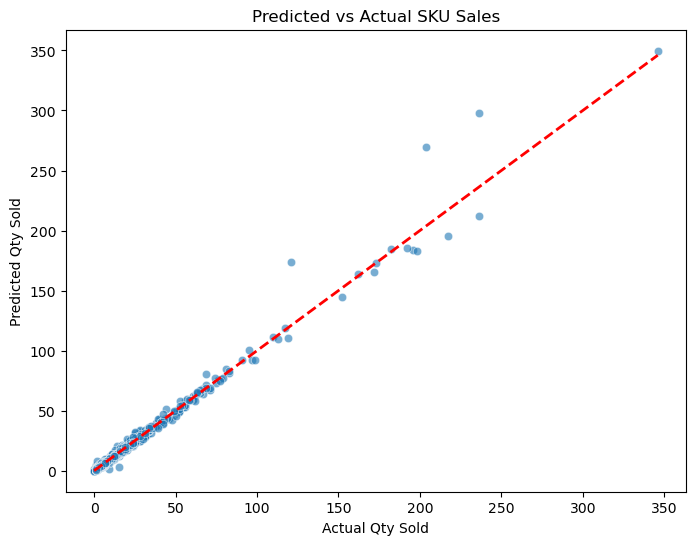

C:\Users\anria\AppData\Local\Temp\ipykernel_31468\849624309.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances.head(15).values, y=importances.head(15).index, palette="viridis")


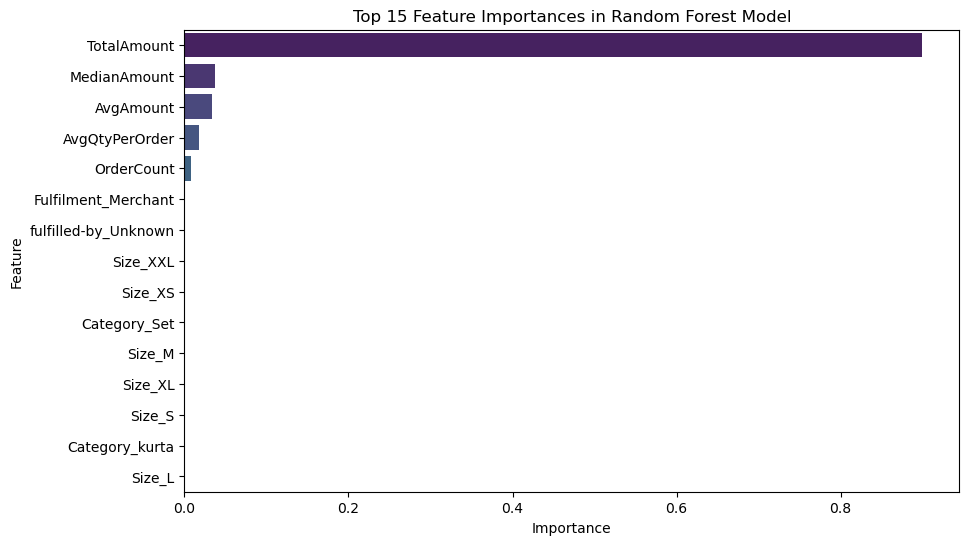

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


# 1. Predicted vs Actual Sales
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test_actual, y=y_pred_actual, alpha=0.6)
plt.plot([y_test_actual.min(), y_test_actual.max()],
         [y_test_actual.min(), y_test_actual.max()],
         color='red', lw=2, linestyle='--')
plt.xlabel("Actual Qty Sold")
plt.ylabel("Predicted Qty Sold")
plt.title("Predicted vs Actual SKU Sales")
plt.show()


# 2. Top 15 Feature Importances

plt.figure(figsize=(10,6))
sns.barplot(x=importances.head(15).values, y=importances.head(15).index, palette="viridis")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Top 15 Feature Importances in Random Forest Model")
plt.show()